In [2]:
import pandas as pd

In [21]:
# --------------------------
# Material Densities (kN/m3)
# --------------------------
𝝆_con = 24.0
𝝆_scr = 20.0

In [24]:
w_scre = 0.075 * 𝝆_scr
w_slab = 3.0
w_ceil = 0.25
w_flor = round(w_scre + w_slab + w_ceil, 2)
print(f'Floor dead weight = {w_flor} kN/m2')

Floor dead weight = 4.75 kN/m2


In [25]:
appld_LL = 2.5
trib_len = 1.5
dead_udl = round(w_flor * trib_len, 2)
live_udl = round(appld_LL * trib_len, 2)
print(f'Dead UDL = {dead_udl} kN/m')
print(f'Live UDL = {live_udl} kN/m')

Dead UDL = 7.12 kN/m
Live UDL = 3.75 kN/m


In [26]:
import numpy as np

def analyze_beam(spans, loads, supports, E, I,
                 nel_per_span=4, n_plot_per_span=200):
    """
    Beam analysis (Euler-Bernoulli, prismatic, UDL per span).

    Parameters
    ----------
    spans : list[float]
        Span lengths [L1, L2, ..., Ln] in m.
    loads : list[float]
        UDL on each span [w1, w2, ..., wn] in kN/m (positive downward).
    supports : list[str]
        Boundary conditions at original nodes (len = n+1).
        Each entry: 'pin', 'fixed', or 'free'.
        e.g. ['pin', 'pin', 'free'] -> pin-pin with overhang.
    E : float
        Young’s modulus (kN/m²).
    I : float
        Second moment of area (m⁴).
    nel_per_span : int, optional
        Number of FE elements per span (>=2 is usually fine).
    n_plot_per_span : int, optional
        Number of plotting/diagram points per span.

    Returns
    -------
    result : dict
        {
          "x": np.array,   # position along beam (m)
          "v": np.array,   # deflection (m, downward positive)
          "V": np.array,   # shear (kN, upward positive)
          "M": np.array,   # bending moment (kNm, sagging +ve)
          "support_positions": np.array,
          "support_reactions": np.array,  # vertical (kN, upward +ve)
        }
    """
    S = len(spans)
    assert len(loads) == S
    assert len(supports) == S + 1

    # --- refine spans into smaller FE elements ---
    elem_lengths = []
    elem_loads = []
    for Lspan, wspan in zip(spans, loads):
        Le = Lspan / nel_per_span
        for _ in range(nel_per_span):
            elem_lengths.append(Le)
            elem_loads.append(wspan)

    n_elem = len(elem_lengths)
    n_nodes = n_elem + 1
    ndofs = 2 * n_nodes
    EI = E * I

    K = np.zeros((ndofs, ndofs))
    F = np.zeros(ndofs)

    # --- assemble global K and equivalent nodal loads F ---
    for e, (L, w) in enumerate(zip(elem_lengths, elem_loads)):
        L2 = L * L
        L3 = L2 * L
        # 4x4 beam element stiffness matrix
        k = EI / L3 * np.array([
            [ 12,    6*L, -12,    6*L],
            [  6*L,  4*L2, -6*L,  2*L2],
            [-12,   -6*L,  12,   -6*L],
            [  6*L,  2*L2, -6*L,  4*L2],
        ])
        # Consistent nodal loads for UDL w (downward)
        fe = w * L / 2 * np.array([1, L/6, 1, -L/6])

        dofs = [2*e, 2*e+1, 2*(e+1), 2*(e+1)+1]
        for i in range(4):
            F[dofs[i]] += fe[i]
            for j in range(4):
                K[dofs[i], dofs[j]] += k[i, j]

    # --- map original supports -> refined nodes ---
    supports_ref = ['free'] * n_nodes
    for j, bc in enumerate(supports):
        node_idx = j * nel_per_span
        supports_ref[node_idx] = bc

    fixed_dofs = []
    for n, bc in enumerate(supports_ref):
        if bc in ('pin', 'fixed'):
            fixed_dofs.append(2 * n)       # vertical displacement = 0
        if bc == 'fixed':
            fixed_dofs.append(2 * n + 1)   # rotation = 0

    free_dofs = [i for i in range(ndofs) if i not in fixed_dofs]

    # --- solve for nodal displacements ---
    Kff = K[np.ix_(free_dofs, free_dofs)]
    Ff = F[free_dofs]
    d = np.zeros(ndofs)
    d_free = np.linalg.solve(Kff, Ff)
    d[free_dofs] = d_free

    # --- reactions at all refined nodes ---
    R = K.dot(d) - F

    # --- original node positions (span boundaries) ---
    node_pos_orig = [0.0]
    cum = 0.0
    for Lspan in spans:
        cum += Lspan
        node_pos_orig.append(cum)

    # support reactions at original support nodes
    support_positions = []
    support_reactions = []
    for j, bc in enumerate(supports):
        node_idx = j * nel_per_span
        if bc in ('pin', 'fixed'):
            pos = node_pos_orig[j]
            Vj = -R[2 * node_idx]  # upward reaction positive
            support_positions.append(pos)
            support_reactions.append(Vj)

    support_positions = np.array(support_positions)
    support_reactions = np.array(support_reactions)

    # --- deflection field v(x) from FE (Hermite shape in each element) ---
    total_L = sum(spans)
    n_plot = S * n_plot_per_span + 1
    xs = np.linspace(0.0, total_L, n_plot)
    vs = np.zeros_like(xs)

    # element start positions along beam
    elem_starts = [0.0]
    c = 0.0
    for L in elem_lengths:
        c += L
        elem_starts.append(c)
    elem_starts = np.array(elem_starts)

    for i, x in enumerate(xs):
        # find element e where x lies
        e = max(0, min(n_elem-1,
                       np.searchsorted(elem_starts, x, side='right') - 1))
        x0 = elem_starts[e]
        L = elem_lengths[e]
        xi = (x - x0) / L

        dofs = [2*e, 2*e+1, 2*(e+1), 2*(e+1)+1]
        d_e = d[dofs]

        # Hermite shape functions
        N1 = 1 - 3*xi**2 + 2*xi**3
        N2 = L * (xi - 2*xi**2 + xi**3)
        N3 = 3*xi**2 - 2*xi**3
        N4 = L * (-xi**2 + xi**3)

        vs[i] = N1*d_e[0] + N2*d_e[1] + N3*d_e[2] + N4*d_e[3]

    # --- shear V(x) and moment M(x) from statics ---
    Vs = np.zeros_like(xs)
    Ms = np.zeros_like(xs)

    # span boundaries (original grid)
    span_bounds = [0.0]
    c = 0.0
    for Lspan in spans:
        c += Lspan
        span_bounds.append(c)
    span_bounds = np.array(span_bounds)

    for i, x in enumerate(xs):
        # shear: sum of support reactions to the left minus UDL to the left
        mask_r = support_positions <= x + 1e-9
        V_reac = support_reactions[mask_r].sum()

        V_load = 0.0
        for si, Lspan in enumerate(spans):
            span_start = span_bounds[si]
            span_end = span_bounds[si+1]
            if x <= span_start:
                continue
            a = span_start
            b = min(span_end, x)
            if b > a:
                Lseg = b - a
                V_load += loads[si] * Lseg

        Vs[i] = V_reac - V_load  # upward positive

        # bending moment: Σ(Rj * (x - xj)) - ∫ w (x - s) ds
        M_reac = ((x - support_positions[mask_r]) *
                  support_reactions[mask_r]).sum()

        M_load = 0.0
        for si, Lspan in enumerate(spans):
            span_start = span_bounds[si]
            span_end = span_bounds[si+1]
            if x <= span_start:
                continue
            a = span_start
            b = min(span_end, x)
            if b > a:
                Lseg = b - a
                wspan = loads[si]
                # integral of w (x - s) ds from s=a to b
                M_load += wspan * (x*Lseg - (b**2 - a**2)/2.0)

        Ms[i] = M_reac - M_load  # sagging positive

    return {
        "x": xs,
        "v": vs,
        "V": Vs,
        "M": Ms,
        "support_positions": support_positions,
        "support_reactions": support_reactions,
    }

In [29]:
def tip_deflection_overhang(L1, L2, w, E, I):
    """
    Pin at 0, pin at L1, free overhang L2, UDL w over full length.
    Returns downward tip deflection in metres.
    """
    k = L2 * (L1**3 - 4*L1*L2**2 - 3*L2**3) / 24.0
    return k * w / (E * I)

In [46]:
L1 = 4.98
L2 = 1.995
wD = 8.18
wQ = 3.75
w_total = wD + wQ

spans = [L1, L2]
loads = [w_total, w_total]        # same UDL both spans
supports = ['pin', 'pin', 'free']
E  = 210e6    # kN/m^2 (steel)
I  = 2.34e-5  # m^4 for UB 203x133x25

res = analyze_beam(spans, loads, supports, E, I)

x = res["x"]
V = res["V"]
M = res["M"]
v = res["v"]

M_min = round(res["M"].min(), 1)
M_max = round(res["M"].max(), 1)

print("Support positions (m):", res["support_positions"])
print("Support reactions (kN):", res["support_reactions"])
print("Max sagging M (kNm):", M_max)
print("Max hogging M (kNm):", M_min)
print("Max deflection (mm):", v.min() * 1000)  # downward is negative

Support positions (m): [0.   4.98]
Support reactions (kN): [24.93846122 58.27328878]
Max sagging M (kNm): 26.1
Max hogging M (kNm): -23.6
Max deflection (mm): -4.117564758263


In [43]:
dG = tip_deflection_overhang(L1, L2, wD, E, I)
dQ = tip_deflection_overhang(L1, L2, wQ, E, I)
d_total = tip_deflection_overhang(L1, L2, wD + wQ, E, I)

print("Dead defl (mm):  ", dG * 1e3)
print("Live defl (mm):  ", dQ * 1e3)
print("Total defl (mm): ", d_total * 1e3)

Dead defl (mm):   2.8232757521033673
Live defl (mm):   1.2942890061598569
Total defl (mm):  4.117564758263224


UB 203 beam supports profiled metal decking spanning transversely, shot-fixed to the top flange at max 300 mm centres. The composite slab is continuous across the beam. In accordance with SCI P300/P341, the decking and slab provide effective lateral restraint to the compression flange; the beam is therefore designed as laterally restrained in the final condition. No composite action in bending is assumed (no shear studs).

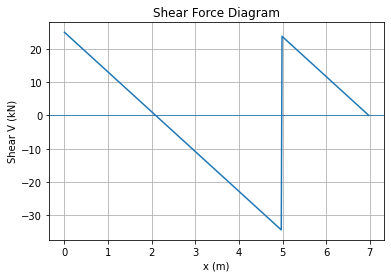

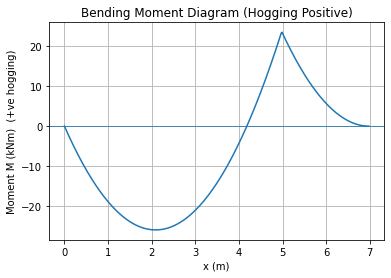

In [48]:
import matplotlib.pyplot as plt

# --- 1. Define your beam and run the analysis ---
L1 = 4.98
L2 = 1.995
w_total = 11.93  # kN/m, e.g. dead + live

spans = [L1, L2]
loads = [w_total, w_total]          # same UDL on both spans
supports = ['pin', 'pin', 'free']

# If you kept the old version of analyze_beam that needs E, I:
E = 210e6      # kN/m² (steel)
I = 2.34e-5    # m⁴ (e.g. UB 203x133x25)
res = analyze_beam(spans, loads, supports, E, I)

# If you later refactor to a statics-only version, you’d just call:
# res = analyze_beam(spans, loads, supports)

x = res["x"]
V = res["V"]   # shear (kN)
M = res["M"]   # bending moment (kNm)

# --- 2. Shear force diagram ---
plt.figure()
plt.plot(x, V)
plt.axhline(0, linewidth=0.8)
plt.xlabel("x (m)")
plt.ylabel("Shear V (kN)")
plt.title("Shear Force Diagram")
plt.grid(True)
plt.show()

# --- 3. Bending moment diagram ---
# Flip sign so hogging is +ve
M_plot = -M

plt.figure()
plt.plot(x, M_plot)
plt.axhline(0, linewidth=0.8)
plt.xlabel("x (m)")
plt.ylabel("Moment M (kNm)  (+ve hogging)")
plt.title("Bending Moment Diagram (Hogging Positive)")
plt.grid(True)
plt.show()